In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats, special
import config
plt.style.use('ggplot')
import datetime
from matplotlib import rc
rc('text', usetex=True)
SMALL_SIZE=15
MEDIUM_SIZE=20
rc('legend', fontsize=MEDIUM_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)

import numpy as np
from numba import jit
from scipy import stats
import time
import matplotlib.pyplot as plt
plt.style.use("ggplot")

$$x(t+1) = x(t) + \frac{x(t)}{\tau_i}\left(1 - \frac{x(t)}{K}\right) + \sqrt{\frac{\sigma}{\tau}}x(t)\xi(t) $$ 

In [9]:
@jit
def SLM(x_0,tau,sgm,K,N,nse):
     
    X = [x_0]
    
    for i in range(N):
        
        X_t = X[-1]
        
        X_t += (X_t/tau)*(1 - X_t/K) + np.sqrt(sgm/tau)*X_t*nse[i]
        
        if X_t < 0:
            X_t = 1e-6
            
        elif X_t > 1:
            X_t = 1-1e-6
        
        X.append(X_t)    
    
    return(X)

In [10]:
N = int(1e5)
K = 2e-4
B = 1
nse = stats.norm.rvs(size=N)
t1 = time.time()

x_list = []
for i in range(100):
    nse = stats.norm.rvs(size=N)
    x = SLM(K,1,B*K**2,K,N,nse)

    x_list.append(x)
    
t2 = time.time()
t2 - t1

1.3750882148742676

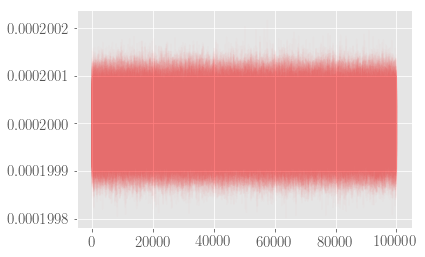

In [4]:
for i in range(50):

    plt.plot(x_list[i],alpha=.01,color="red")
    
#plt.yscale("log")

In [3]:
sra = pd.read_csv("~/diversity_ecology/scripts/metadata/Korpela_SRA_report.txt",sep="\t",
                index_col=5)

In [9]:
def get_clusters_snv_trajectories(snp_map):
    
    clusters = []
    for key in snp_map.keys():
        clusters.append(snp_map[key][1])
    clusters = list(set(clusters))
    
    freqs = {cluster:[] for cluster in clusters}
    for key in snp_map.keys():
        freqs[list(snp_map[key])[1]].append(np.array(list(snp_map[key])[2]/list(snp_map[key][3])))
    
    for key in freqs.keys():
        freqs[key] = np.array(freqs[key])
        
    return freqs

In [7]:
def plot_polarized_snv_trajectories(clusters_snv_trajectories,good_inds,ax,num_snps=1000,alpha=.01,):
    #fig,ax = plt.subplots(figsize=(12,8))
    
    for cluster in clusters_snv_trajectories.keys():
        cluster_snvs = clusters_snv_trajectories[cluster].T
        ax.plot(cluster_snvs[good_inds,:1000],alpha=alpha,color="grey");
    
    ax.set_xlabel("Timepoint")
    ax.set_ylabel("Frequency")

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


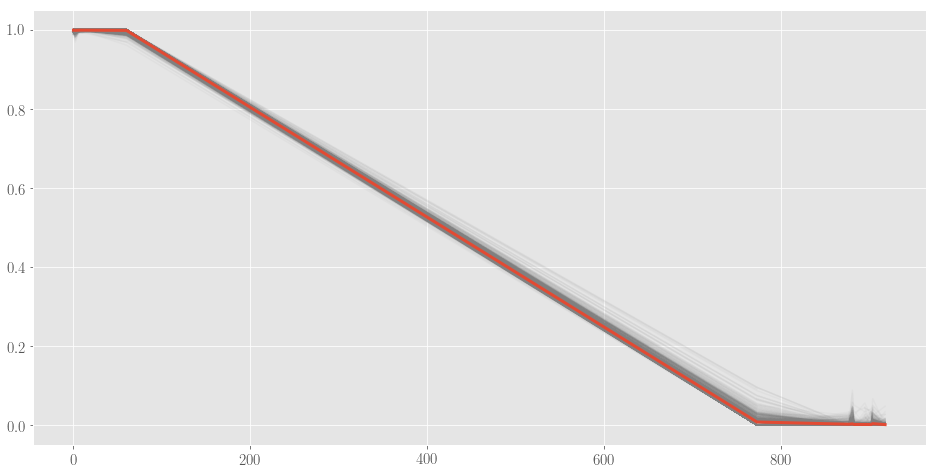

In [22]:
species = "Ruminoc"
host = "alien"
output_directory = "/u/scratch/r/rwolff/strainfinder_input/Korpela/%s" % host
filename_prefix = "%s/%s" % (output_directory, species)
#snp_locations = pickle.load(open(filename_prefix+".strainfinder.locations.p",'rb'))
snp_alignment = pd.read_pickle(filename_prefix+".strainfinder.p")
snp_samples = pickle.load(open(filename_prefix+".strainfinder.samples.p",'rb'))
snp_samples = [elem.decode("utf-8") for elem in snp_samples]
sample_sra = sra.loc[[elem[1:] for elem in snp_samples]]
dates = [d[2] for d in sample_sra["sample_alias"].str.split("-")]
dates = {("c"+ind):int(sample_sra.loc[ind]["sample_alias"].split("-")[2]) for ind in sample_sra.index}
outp=pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_strain_frequencies.pkl")

cluster_As = snp_alignment[:,:,0].T
cluster_Ds = (snp_alignment.sum(axis=2)).T

good_inds = cluster_Ds.mean(axis=0) > 2
good_inds = np.argwhere(good_inds == True).flatten()

snp_map = pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_snp_map.pkl")
freqs = get_clusters_snv_trajectories(snp_map)
strain_df = pd.DataFrame(columns=outp.keys())
for K in outp.keys():
    strain_freq_est = outp[K]["centroid"][0]
    strain_df[K] = strain_freq_est
strain_df.index = snp_samples
strain_df["Collection_Date"] = pd.Series(dates)
strain_df = strain_df.sort_values("Collection_Date")
strain_df["Order"] = range(strain_df.shape[0])
sample_order = np.array(list(strain_df.loc[snp_samples]["Order"]))
idx = np.empty_like(sample_order)
idx[sample_order] = np.arange(len(sample_order))
strain_freqs = pd.DataFrame(index=strain_df.index,columns=outp.keys())

strain_freqs[list(outp.keys())] = strain_df[outp.keys()]
out_strain_num = max(list(outp.keys())) + 1
fig,ax = plt.subplots(1,figsize=(16,8))

for key in freqs.keys():
    ax.plot(list(strain_df["Collection_Date"])[:-1],freqs[key].T[idx,:1000][:-1],color="grey",alpha=.05);

ax.plot(list(strain_df["Collection_Date"])[:-1],strain_freqs[:-1],linewidth=3);

In [32]:
np.insert(np.diff(sorted(np.array(list(dates.values())))),0,0)

array([  0,   2,   5,  53, 713, 104,   4,   2,  12,   7,   2,  14, 444])

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


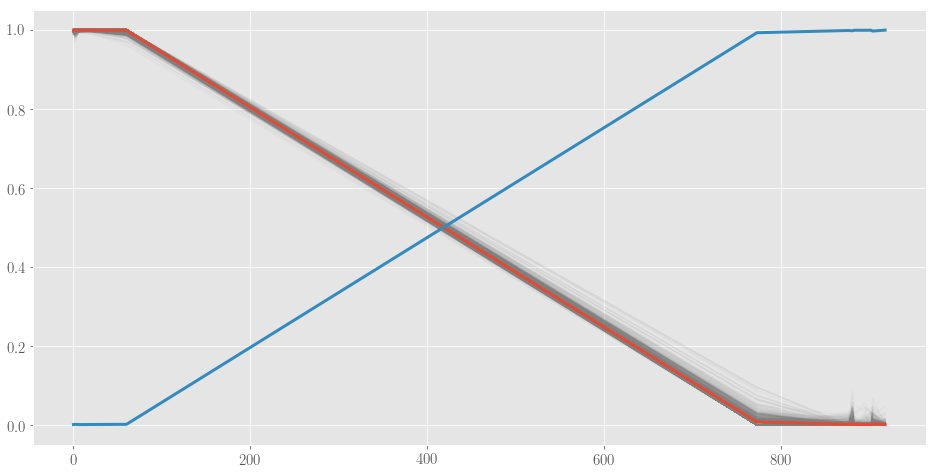

In [15]:
outp=pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_strain_frequencies.pkl")

cluster_As = snp_alignment[:,:,0].T
cluster_Ds = (snp_alignment.sum(axis=2)).T

good_inds = cluster_Ds.mean(axis=0) > 2
good_inds = np.argwhere(good_inds == True).flatten()

snp_map = pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_snp_map.pkl")
freqs = get_clusters_snv_trajectories(snp_map)
strain_df = pd.DataFrame(columns=outp.keys())
for K in outp.keys():
    strain_freq_est = outp[K]["centroid"][0]
    strain_df[K] = strain_freq_est
strain_df.index = snp_samples
strain_df["Collection_Date"] = pd.Series(dates)
strain_df = strain_df.sort_values("Collection_Date")
strain_df["Order"] = range(strain_df.shape[0])
sample_order = np.array(list(strain_df.loc[snp_samples]["Order"]))
idx = np.empty_like(sample_order)
idx[sample_order] = np.arange(len(sample_order))
strain_freqs = pd.DataFrame(index=strain_df.index,columns=outp.keys())

strain_freqs[list(outp.keys())] = strain_df[outp.keys()]
out_strain_num = max(list(outp.keys())) + 1

strain_freqs[out_strain_num] = 1 - strain_freqs.T.sum()

fig,ax = plt.subplots(1,figsize=(16,8))

for key in freqs.keys():
    ax.plot(list(strain_df["Collection_Date"])[:-1],freqs[key].T[idx,:1000][:-1],color="grey",alpha=.05);

ax.plot(list(strain_df["Collection_Date"])[:-1],strain_freqs[:-1],linewidth=3);

In [16]:
rel_ab = pd.read_csv("/u/scratch/r/rwolff/merged_MIDAS_output/Korpela/species/relative_abundance.txt.bz2",sep="\t",index_col=0)
spec_rel_ab = rel_ab.loc[species]
spec_rel_ab = spec_rel_ab.loc[strain_df.index]
strain_total_freqs = (strain_freqs.T*spec_rel_ab).T

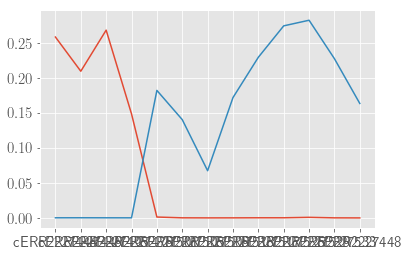

In [17]:
plt.plot(strain_total_freqs)

In [ ]:
strain_total_freqs.mean()

In [70]:
strain = 9
#K = 2*strain_total_freqs.mean()[strain]
#sigma = strain_total_freqs.var()[strain]
#sigma = 1
#K = K
#sigma = s
s = 2/(1/.17+1)
K = (strain_total_freqs.iloc[:-1].mean()[strain]/(1-(s/2)))

x0 = strain_total_freqs.iloc[0][strain]


In [71]:
N = max(list(strain_df["Collection_Date"]))
nse = stats.norm.rvs(size=N)

x_list = []
for i in range(int(1e4)):
    nse = stats.norm.rvs(size=N)
    x = SLM(x0,19,s,K,N,nse)
    x_list.append(x)

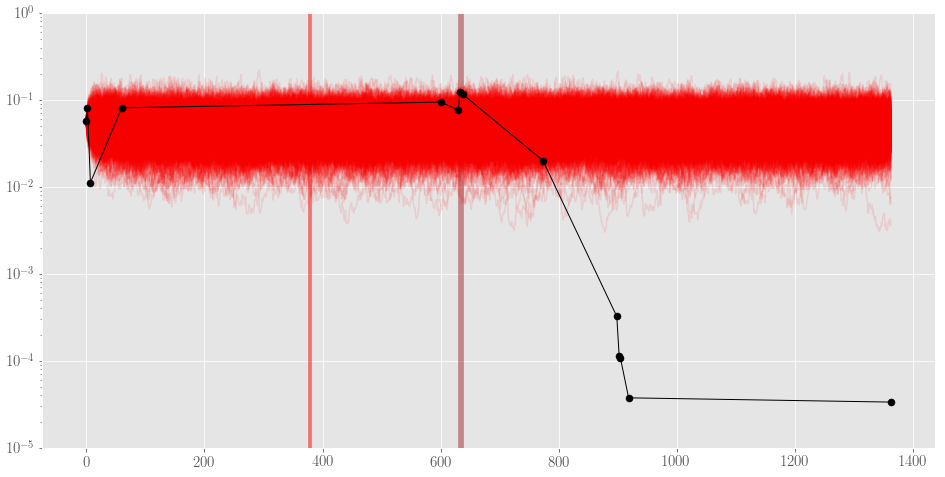

In [72]:
fig,ax = plt.subplots(figsize=(16,8))

for i in range(1000):
    
    ax.plot(x_list[i],alpha=.1,color="red",zorder=1)
    
ax.plot(list(strain_df["Collection_Date"]),strain_total_freqs[strain],color="k",linewidth=1)
ax.scatter(list(strain_df["Collection_Date"]),strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

ax.set_ylim([1e-5,1]);

if host == "alien":
    ax.axvspan(376, 380, alpha=0.5, color='red')
    ax.axvspan(630, 637, alpha=0.5, color='brown')

ax.set_yscale("log")

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


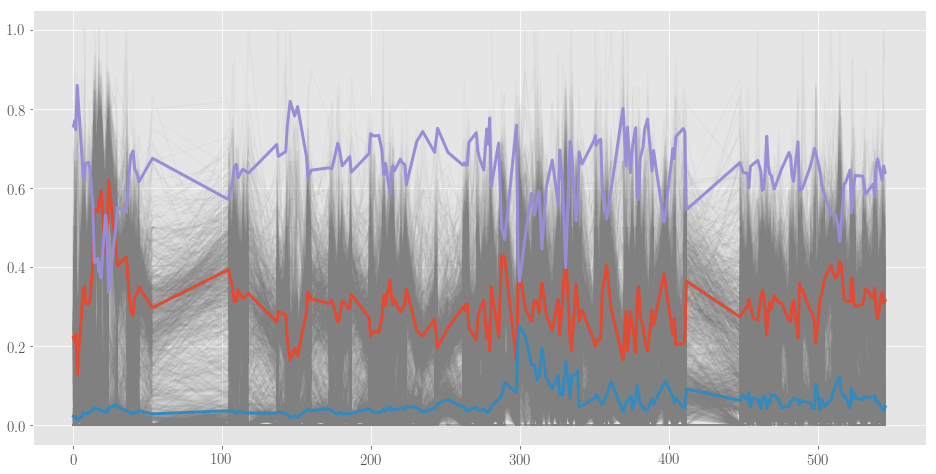

In [14]:
species = "Bacteroides_vulgatus_57955"
host = "am"
output_directory = "/u/scratch/r/rwolff/strainfinder_input/%s" % host
filename_prefix = "%s/%s" % (output_directory, species)
snp_locations = pickle.load(open(filename_prefix+".strainfinder.locations.p",'rb'))
snp_alignment = pd.read_pickle(filename_prefix+".strainfinder.p")
snp_samples = pickle.load(open(filename_prefix+".strainfinder.samples.p",'rb'))
snp_samples = [elem.decode("utf-8") for elem in snp_samples]


dates = pd.read_pickle("metadata/Poyet_collection_dates.pkl")
dates = pd.DataFrame(dates)
#dates = dates.loc[snp_samples]

dates["Collection_Date"] = pd.to_datetime(dates.Collection_Date)

outp=pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_strain_frequencies.pkl")

cluster_As = snp_alignment[:,:,0].T
cluster_Ds = (snp_alignment.sum(axis=2)).T

good_inds = cluster_Ds.mean(axis=0) > 1
good_inds = np.argwhere(good_inds == True).flatten()

snp_map = pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_snp_map.pkl")
freqs = get_clusters_snv_trajectories(snp_map)

strain_df = pd.DataFrame(columns=outp.keys())
for K in outp.keys():
    strain_freq_est = outp[K]["centroid"][0]
    strain_df[K] = strain_freq_est

strain_df.index = snp_samples

strain_df["Collection_Date"] = dates["Collection_Date"]
strain_df["Collection_Date"] = dates["Collection_Date"]
strain_df = strain_df.sort_values("Collection_Date")
strain_df["Date_Diffs"] = strain_df["Collection_Date"].diff().dt.days
strain_df["Date_Diffs"] = strain_df["Date_Diffs"].replace(0.0,.5)
strain_df["Date_Diffs"][0] = 0.0
strain_df["Order"] = range(strain_df.shape[0])
sample_order = np.array(list(strain_df.loc[snp_samples]["Order"]))
idx = np.empty_like(sample_order)
idx[sample_order] = np.arange(len(sample_order))

strain_freqs = pd.DataFrame(index=strain_df.index,columns=outp.keys())

strain_freqs[list(outp.keys())] = strain_df[outp.keys()]
out_strain_num = max(list(outp.keys())) + 1
strain_freqs[out_strain_num] = 1 - strain_freqs.T.sum()
times = np.array(list(strain_df["Date_Diffs"].cumsum()))

fig,ax = plt.subplots(1,figsize=(16,8))

for key in freqs.keys():
    ax.plot(times,freqs[key].T[idx,:1000],color="grey",alpha=.05);

ax.plot(times,strain_freqs.values,linewidth=3);


In [15]:
rel_ab = pd.read_csv("/u/scratch/r/rwolff/merged_MIDAS_output/%s/species/relative_abundance.txt" % host,sep="\t",index_col=0)
spec_rel_ab = rel_ab.loc[species]
spec_rel_ab = spec_rel_ab.loc[strain_df.index]
strain_total_freqs = (strain_freqs.T*spec_rel_ab).T

In [16]:
strain = 1
#K = 2*strain_total_freqs.mean()[strain]
#sigma = strain_total_freqs.var()[strain]
#sigma = 1
#K = K
#sigma = s
s = 2/(1/.17+1)
K = (strain_total_freqs.mean()[strain]/(1-(s/2)))

In [22]:
N = int(max(times))
nse = stats.norm.rvs(size=N)
t1 = time.time()

x0 = strain_total_freqs.iloc[0][strain]
#x0 = .6
x_list = []
for i in range(int(1e3)):
    nse = stats.norm.rvs(size=N)
    x = SLM(x0,19/24,s/5,K,N,nse)
    x_list.append(x)

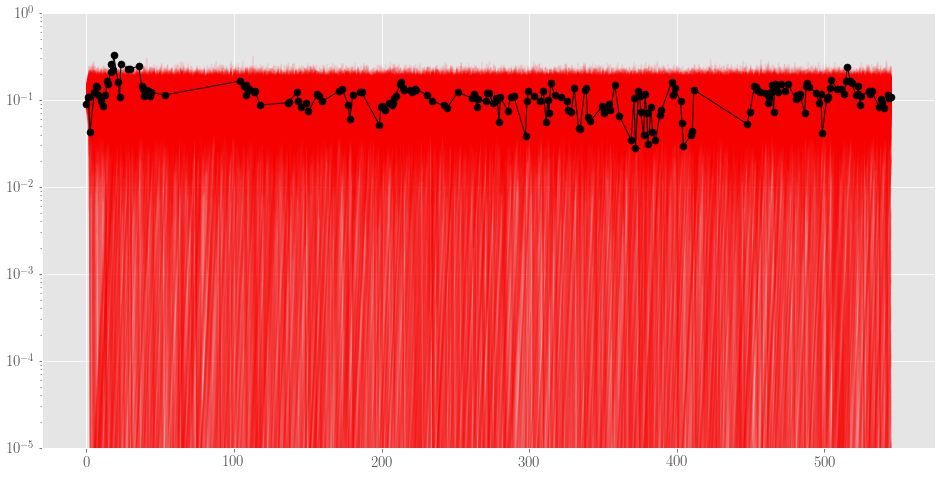

In [23]:
fig,ax = plt.subplots(figsize=(16,8))

for i in range(1000):
    
    ax.plot(x_list[i],alpha=.1,color="red",zorder=1)
    
ax.plot(times,strain_total_freqs[strain],color="k",linewidth=1)
ax.scatter(times,strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

ax.set_ylim([1e-5,1]);

ax.set_yscale("log")

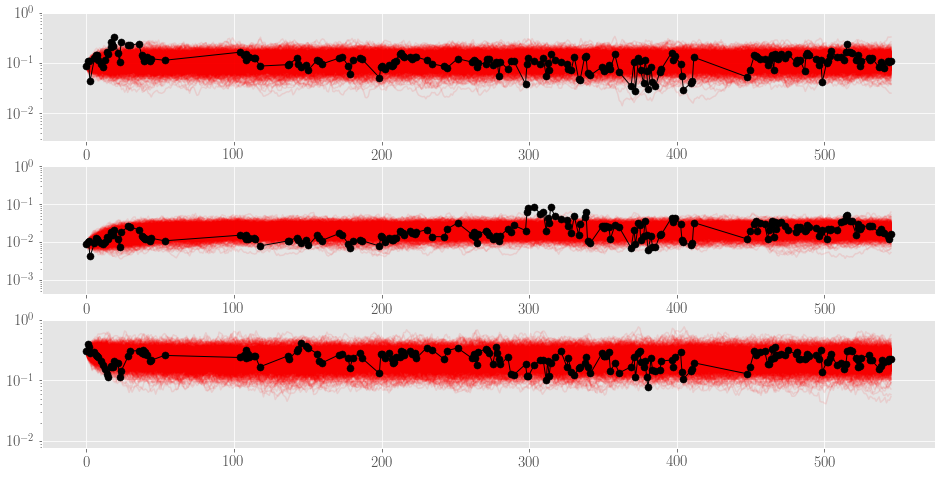

In [52]:
fig,axs = plt.subplots(len(strain_total_freqs.mean()),figsize=(16,8))
axs = axs.ravel()
s = .17 

i = 0
for strain in strain_total_freqs.columns:
    K = (strain_total_freqs.mean()[strain]/(1-(s/2)))

    N = int(max(times))
    nse = stats.norm.rvs(size=N)
    t1 = time.time()

    x0 = strain_total_freqs.iloc[0][strain]
#x0 = .6
    x_list = []
    for j in range(int(1e5)):
        nse = stats.norm.rvs(size=N)
        x = SLM(x0,19,s,K,N,nse)
        x_list.append(x)
    
    for k in range(1000):
    
        axs[i].plot(x_list[k],alpha=.1,color="red",zorder=1)
        
    axs[i].plot(times,strain_total_freqs[strain],color="k",linewidth=1)
    axs[i].scatter(times,strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

    axs[i].set_ylim([.1*min(strain_total_freqs[strain]),1]);

    axs[i].set_yscale("log")
    i+=1    

In [26]:
x_all = np.ravel(np.array(x_list))

In [27]:
x_means = np.array([np.mean(np.array(elem)) for elem in x_all[:10000]])

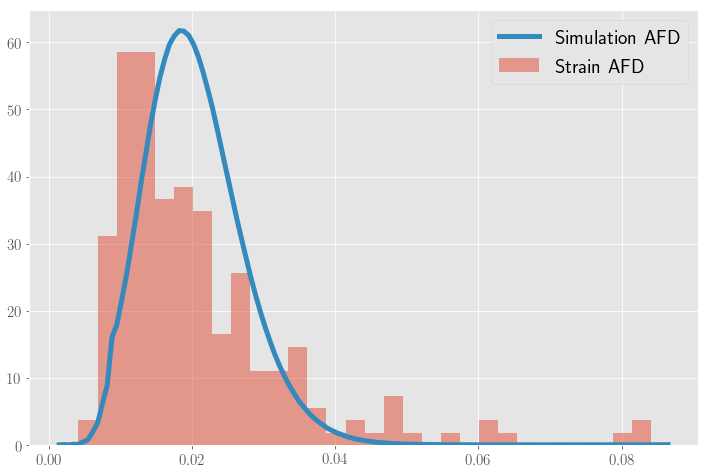

In [31]:
#h=plt.hist(x_all,bins=200,density=True);
#plt.close()
fig,ax = plt.subplots(figsize=(12,8))
#ax.plot(h[1][1:],h[0])
ax.hist(strain_total_freqs[strain],bins=30,alpha=.5,density=True,label="Strain AFD");
sns.kdeplot(x_all,linewidth=5,label="Simulation AFD");
#ax.semilogy();
#fig.legend();

$$\alpha = 2\sigma^{-1} -1 $$ 

$$\beta = \frac{2}{K}\sigma^{-1} $$

$$\text{variance} = \frac{\alpha}{\beta^2}$$

$$ = \frac{2\sigma^{-1} - 1}{(\frac{2}{K}\sigma^{-1})^2} $$

$$ = \frac{K\sigma}{2} - \left(\frac{K\sigma}{2}\right)^2$$ 

$$ \bar{x} = K\left(1 - \frac{\sigma}{2}\right)$$ 

$$ \rho_i(x) = \frac{1}{\Gamma(2\sigma_i^{-1} - 1)}\left( \frac{2}{K_i\sigma_i} \right)^{2\sigma_i^{-1} - 1}\exp\left( -\frac{2}{K_i\sigma_i} \right)x^{2\sigma_i^{-1} -2}$$

$$ \alpha = 2\sigma_i^{-1} -1, \quad \beta = \frac{2}{K_i\sigma_i}$$

In [31]:
def gamma_pdf(K,sigma,x):
    
    alpha = 2/sigma - 1
    beta = 2/(K*sigma)
    
    return (1/special.gamma(alpha))*(beta**alpha) * np.exp(-beta*x)*(x**(alpha - 1))

In [42]:
loglik = sum([np.log(gamma_pdf(K,s,x)) for x in strain_total_freqs[strain]])

In [46]:
xx = [gamma_pdf(K,s,x) for x in np.linspace(0,1,1000)]

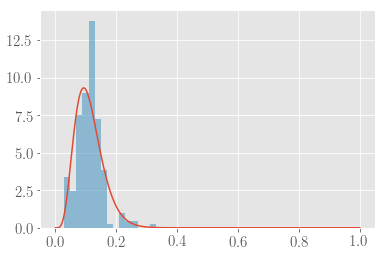

In [50]:
plt.plot(np.linspace(0,1,1000),xx)
plt.hist(strain_total_freqs[strain],bins=15,alpha=.5,density=True,label="Strain AFD");

In [51]:
strain_total_freqs

,1,2,3
SRR9224357,0.088682,0.009021,0.302910
SRR9224359,0.108794,0.010094,0.398899
SRR9224360,0.108844,0.010630,0.352631
SRR9224362,0.042939,0.004164,0.287468
SRR9224245,0.124037,0.009226,0.297540
...,...,...,...
SRR9224198,0.092481,0.018996,0.213644
SRR9224199,0.080904,0.017829,0.203103
SRR9224204,0.112369,0.014442,0.206227
SRR9224205,0.104376,0.012095,0.221627


In [53]:
loglik

363.3682838877361